In [1]:
import numpy as np
import tqdm as tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
def p_a_public_belief(a,obs_dist,utility,obs,A,P,public_belief):
    flag = True
    obs_prob = np.diag(obs_dist[:,obs])  
    for a_ in range(A):
        flag = flag and utility[:,a].T@obs_prob@P.T@public_belief >= utility[:,a_].T@obs_prob@P.T@public_belief
    return flag

def T(public_belief,a,X,O,obs_dist,P,A,utility):
    R_a_pi = np.identity(X)
    for x in range(X):
        for o in range(O):
            R_a_pi[x,x] += p_a_public_belief(a,obs_dist,utility,o,A,P,public_belief) * obs_dist[x,o]
    return R_a_pi@P.T@public_belief

### perturbed identity matrix
def perturbed_identity(X,epsilon):
    P = np.identity(X) + epsilon*np.random.rand(X,X)
    P = P / P.sum(axis=1)[:,None]
    return P

In [54]:
#### Run the experiment for the given parameters
def run_experiment():
    
    X = 2
    O = 2
    A = 2
    n_avg = 1000
    time_range = 100

    obs_dist = np.array([[0.7,0.3],[0.3,0.7]])
    utility = np.array([[1,0],[0,1]])
    cost = np.array([[0,10],[10,0]])
    
    incentive_coefficient = np.array([0.8,1.3]) ### omega_1, omega_2 \costconstanttwo 
    misclassification_coefficient = np.array([0.2,0.5]) ### alpha_1, alpha_2 \costconstantone
    privacy_cost = np.array([0.1,0.5]) ### delta_1, delta_2 \actioncost

    policy_threshold = 0.4
    incentive_fn = lambda pi,y: ((cost[0,1]*(np.diag(obs_dist[:,y])@pi)[0]-cost[1,0]*(np.diag(obs_dist[:,y])@pi)[1])/(incentive_coefficient[1]-incentive_coefficient[0]))/np.sum(np.diag(obs_dist[:,y])@pi)
    incentives = np.zeros((n_avg,time_range))
    public_beliefs = np.zeros((n_avg,time_range,2))
    for i in tqdm.tqdm(range(n_avg)):
        public_belief = np.array([0.5,0.5])
        state = 1
        for t in range(time_range):
            obs = np.random.choice(range(O),p=obs_dist[state])
            
            

            obs_prob = np.diag(obs_dist[:,obs])
            if public_belief[0] >= policy_threshold:
                incentive = incentive_fn(public_belief,obs)
            else:   
                incentive = 0

            private_belief = obs_prob @ public_belief
            normalization_factor = np.ones((1, O)) @ obs_dist.T @ public_belief
            private_belief = private_belief / normalization_factor
            action = np.argmax(utility.T @ private_belief + incentive_coefficient*incentive - privacy_cost)

            public_belief = T(public_belief, action, X, O, obs_dist, np.eye(X), A, utility)
            public_belief = public_belief / np.sum(public_belief)
            incentives[i,t] = incentive
            public_beliefs[i,t] = public_belief
    return public_beliefs, incentives



public_beliefs,incentives = run_experiment()

            


100%|██████████| 1000/1000 [00:06<00:00, 160.31it/s]


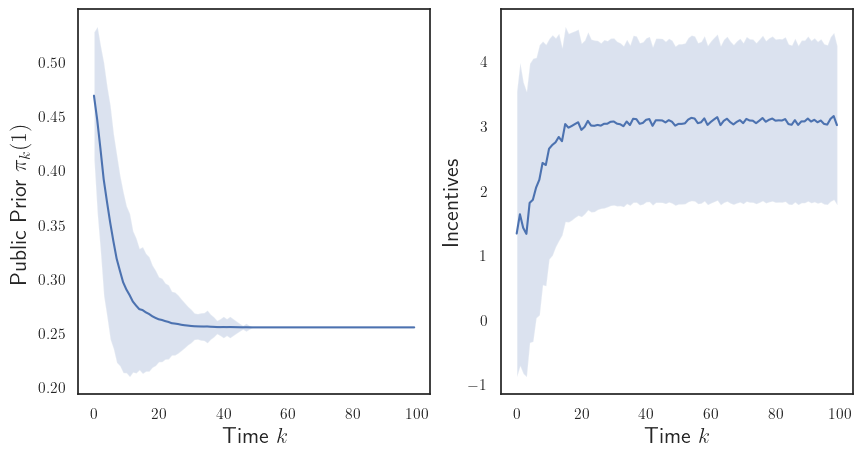

In [55]:

sns.set(style="white")
matplotlib.rcParams.update({'font.size': 12,'text.usetex': True})    
fig,axs = plt.subplots(1,2,figsize=(10,5))
axs[0].plot(np.mean(public_beliefs, axis=0)[:,1])
axs[0].set_ylabel('Public Prior $\pi_k(1)$', fontsize=16)
axs[0].fill_between(range(100), np.mean(public_beliefs, axis=0)[:,1]-np.std(public_beliefs, axis=0)[:,1], np.mean(public_beliefs, axis=0)[:,1]+np.std(public_beliefs, axis=0)[:,1], alpha=0.2)
axs[1].plot(np.mean(np.clip(incentives,0,5), axis=0))
axs[1].fill_between(range(100), np.mean(np.clip(incentives,0,5), axis=0)-np.std(np.clip(incentives,0,5), axis=0), np.mean(np.clip(incentives,0,5), axis=0)+np.std(np.clip(incentives,0,5), axis=0), alpha=0.2)
axs[1].set_ylabel('Incentives', fontsize=16)
axs[0].set_xlabel('Time $k$', fontsize=16)
axs[1].set_xlabel('Time $k$', fontsize=16)
plt.savefig('plots/incentivizedexample.pdf', bbox_inches='tight')


In [ ]:
def run_experiment(policy_threshold,n_avg,time_range):
    
    X = 2
    O = 2
    A = 2

    obs_dist = np.array([[0.6,0.4],[0.2,0.8]])
    utility = np.array([[1,0],[0,1]])
    cost = np.array([[0,1],[1,0]])
    
    incentive_coefficient = np.array([0.4,0.2])
    misclassification_coefficient = np.array([0.4,0.4])
    privacy_cost = np.array([0.4,0.4])
    action_cost = np.array([0.1,0.1])

    incentive_fn = lambda pi,y: (((cost[0,1]*(np.diag(obs_dist[:,y])@pi)[0]-cost[1,0]*(np.diag(obs_dist[:,y])@pi)[1])+action_cost[0]-action_cost[1])/(incentive_coefficient[1]-incentive_coefficient[0]))/np.sum(np.diag(obs_dist[:,y])@pi)

    incentives = np.zeros((n_avg,time_range))
    public_beliefs = np.zeros((n_avg,time_range,2))
    classifications = np.zeros((n_avg,1))
    for i in range(n_avg):
        public_belief = np.array([0.5,0.5])
        state = np.random.choice(range(X))
        for t in range(time_range):
            obs = np.random.choice(range(O),p=obs_dist[state])
            
            

            obs_prob = np.diag(obs_dist[:,obs])
            if public_belief[0] >= policy_threshold:
                incentive = incentive_fn(public_belief,obs)
                # incentive = np.clip(incentive,0,2)

            else:   
                incentive = 0

            private_belief = obs_prob @ public_belief
            normalization_factor = np.ones((1, O)) @ obs_dist.T @ public_belief
            private_belief = private_belief / normalization_factor
            action = np.argmax(utility.T @ private_belief + incentive_coefficient*incentive - privacy_cost+action_cost)

            public_belief = T(public_belief, action, X, O, obs_dist, np.eye(X), A, utility)
            public_belief = public_belief / np.sum(public_belief)
            incentives[i,t] = incentive
            public_beliefs[i,t] = public_belief
        classifications[i] = np.argmax(public_belief)==state
    return public_beliefs, incentives.sum(axis=1).mean(axis=0),classifications



100it [00:22,  4.36it/s]


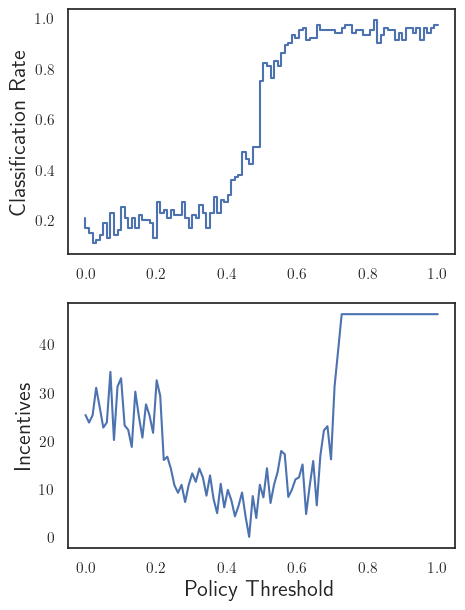

In [ ]:
fig,axs = plt.subplots(2,1,figsize=(5,7))
n_avg = 100
grid_size = 100

threshold_grid = np.linspace(0,1,grid_size)
incentives = np.zeros((len(threshold_grid)))
classifications = np.zeros((len(threshold_grid),n_avg,1))
for i,threshold in tqdm.tqdm(enumerate(threshold_grid)):
    _,incentives[i],classifications[i] = run_experiment(threshold,n_avg,time_range)

axs[0].step(threshold_grid,np.mean(classifications, axis=1))
axs[0].set_ylabel('Classification Rate', fontsize=16)
axs[1].plot(threshold_grid,incentives-np.min(incentives))
axs[1].set_ylabel('Incentives', fontsize=16)
axs[1].set_xlabel('Policy Threshold', fontsize=16)
plt.savefig('plots/incentivizedexample_threshold_vary.pdf', bbox_inches='tight')
plt.show()

In [52]:
#### Run the eperiment with SPSA
n_avg = 1000
time_range = 10

n_iter = 100
parameters = np.ones(n_iter)*np.pi/16
incentives = np.zeros((n_iter,1))
delta = 1
step_sizes = np.linspace(0.5,0.05,n_iter)
for i in tqdm.tqdm(range(1,n_iter)):
    parameters_plus = parameters[i-1] + delta
    threshold_plus = np.sin(parameters_plus)**2
    _,incentives_plus,_ = run_experiment(threshold_plus,n_avg,time_range)
    parameters_minus = parameters[i-1] - delta
    threshold_minus = np.sin(parameters_minus)**2
    _,incentives_minus,_ = run_experiment(threshold_minus,n_avg,time_range)
    parameters[i] = parameters[i-1] - step_sizes[i]*(incentives_plus - incentives_minus)/(2*delta) #+ np.random.normal(0,0.1)
    # parameters[i] = np.clip(parameters[i],-2*np.pi,2*np.pi)
    threshold = np.sin(parameters[i])**2
    _,incentives[i],_ = run_experiment(threshold,n_avg,time_range)
    delta = delta
    # print(threshold_minus,threshold_plus,incentives_minus,incentives_plus,)


100%|██████████| 99/99 [02:54<00:00,  1.77s/it]


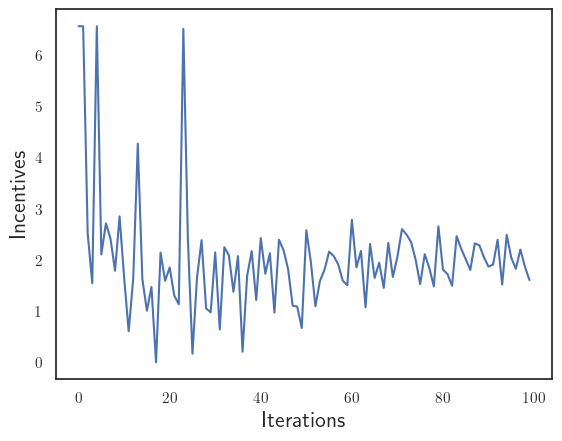

In [51]:
plt.plot(np.arange(n_iter),incentives-np.min(incentives))
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Incentives", fontsize=16)
plt.savefig('plots/incentives_optimization.pdf', bbox_inches='tight')